In [1]:
#importing the libaries
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
#Export data from cryptocompare
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
#Drop two columns from the dataset
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [4]:
#List the first 5 rows from the dataset
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-01-01,60728.90,58355.63,58571.43,4458.05,2.656027e+08,60487.33
2022-01-02,60758.59,58860.21,60487.33,3546.05,2.117553e+08,59995.07
2022-01-03,60464.22,58158.24,59995.07,4259.27,2.535241e+08,59331.80
2022-01-04,60501.41,57777.74,59331.80,4063.50,2.400628e+08,58337.03
2022-01-05,59401.10,53991.65,58337.03,963.23,5.637792e+07,55385.55


In [5]:
#Defining a function to split the dataset for training and testing
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [6]:
#Split the data 80% to train and 20% to test data
train, test = train_test_split(hist, test_size=0.2)

In [7]:
#Defining a function for plot a line graph on the price
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

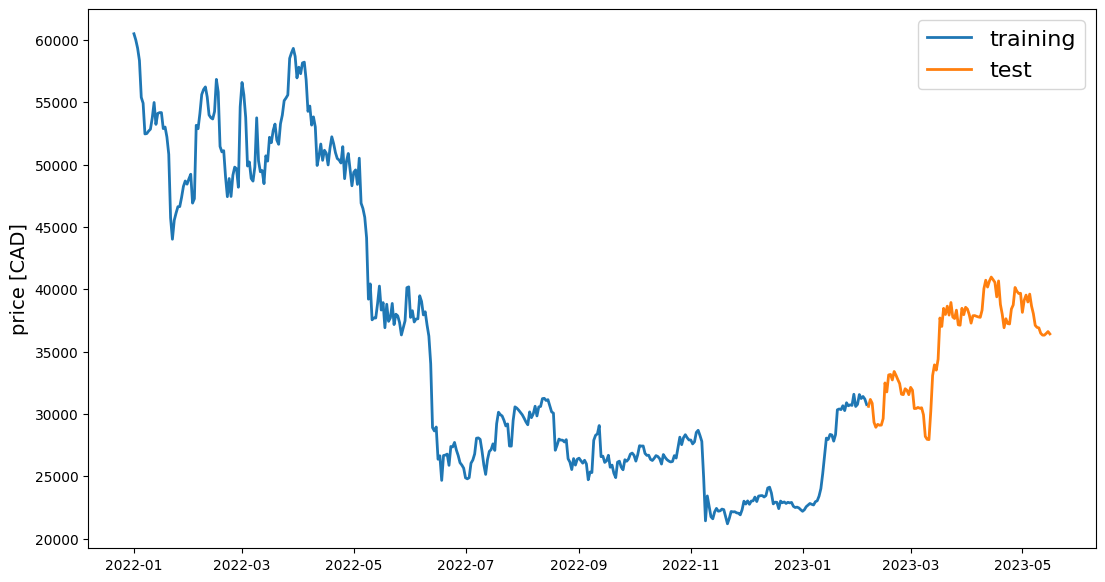

In [8]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [9]:
#Defining functions for price prediction
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [10]:
#Defining functions for price prediction
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [11]:
#Preparing functions for train the data
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [12]:
#Applying LSTM model for the price prediction
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [13]:
#Settings up the values for train the data
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [14]:
#Preparing data for training
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [15]:
#Using LSTM model training the data
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 4s 82ms/step - loss: 0.0100 - val_loss: 0.0037
Epoch 2/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 3/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 6/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 7/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 9/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 10/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 11/20

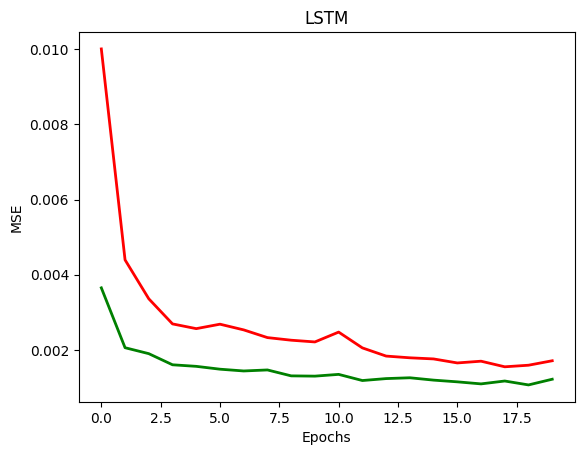

In [16]:
#Plotting the validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [17]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

3/3 [==============================] - 0s 5ms/step


0.022077967858596958

In [18]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


0.001217897069083417

In [19]:
#Getting the accuracy score of our price prediction
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.757630261347353

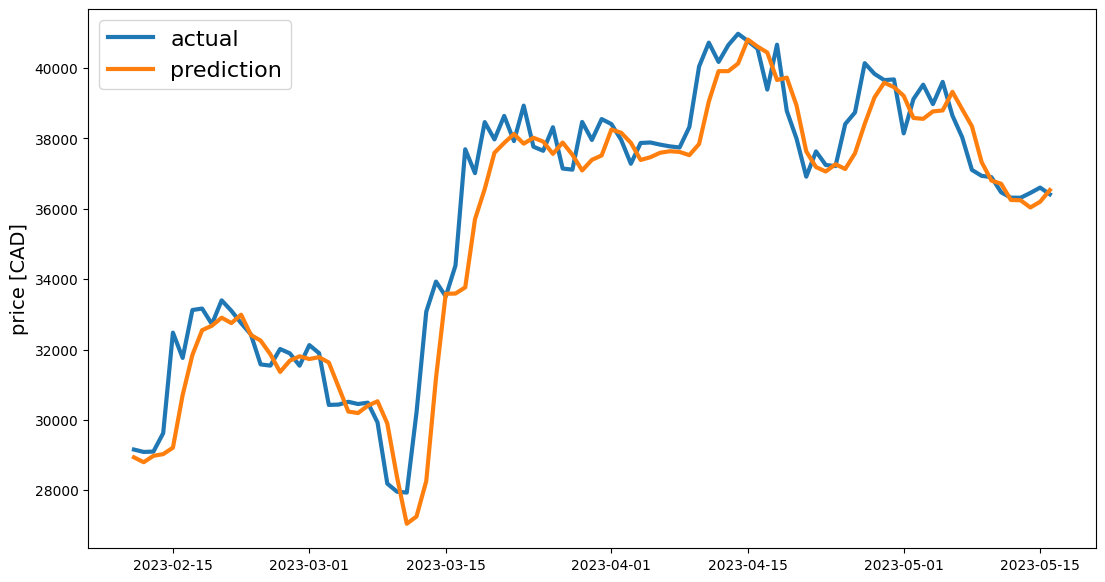

In [20]:
#Prediction of price is plotted
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)